# ***Importing the libraries***

In [625]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from random import randint

import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import shap
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from xgboost import XGBRegressor, plot_importance


# ***Defining functions***

In [626]:
COLORS = ['#8c1b3f','#fe0151', '#0c7ff4', '#3eb1ff']
CMAP = LinearSegmentedColormap.from_list('my_cmap', COLORS)

def print_regression_report(x_test, y_test, model, title):
    y_hat = truncate_prediction(model, x_test)
    
    print(f'{"="*53}\n{title}\n{"="*53}')
    print('Mean Squared Error:\t\t', mean_squared_error(y_test, y_hat))
    print('Mean Absolute Error:\t\t', mean_absolute_error(y_test, y_hat))
    print('R²:\t\t\t\t', r2_score(y_test, y_hat))
    print('Root Mean Squared Error:\t', np.sqrt(mean_squared_error(y_test, y_hat)))
    
    
def plot_residual_distribution(x_test, y_test, model, title):
    residuals = y_test - truncate_prediction(model, x_test)
    
    plt.figure(figsize=(10, 6))
    ax = sns.histplot(residuals, color=COLORS[2], kde=True, label='Residuals', line_kws={'linewidth': 2, 'label': 'Density'})
    ax.set_title(f'Residuals distribution - {title}')
    ax.set_xlabel('Residual value')
    ax.set_ylabel('')
    ax.vlines(0, ax.get_ylim()[0], ax.get_ylim()[1], colors=COLORS[1], linestyles=':', label='Zero', linewidth=3)
    ax.legend();
    
def plot_residual_comparison(x_test, y_test, model, title):
    residuals = y_test - truncate_prediction(model, x_test)
    
    plt.figure(figsize=(10, 6))
    ax = sns.scatterplot(x=y_test, y=residuals, color=COLORS[2], label='Residuals')
    ax.set_title(f'Residuals comparison - {title}')
    ax.set_xlabel('True value')
    ax.set_ylabel('Residual value')
    ax.hlines(0, 0, 1, colors=COLORS[1], linestyles=':', label='Zero', linewidth=3)
    ax.hlines(mean_absolute_error(y_test, truncate_prediction(model, x_test)), 0, 1, colors=COLORS[0], linestyles='--', label='MAE', linewidth=2)
    ax.hlines(-mean_absolute_error(y_test, truncate_prediction(model, x_test)), 0, 1, colors=COLORS[0], linestyles='--', linewidth=2)
    ax.legend();
    
def plot_feature_importance(model, x_test):
    explaner = shap.TreeExplainer(model)
    shap_values = explaner.shap_values(x_test)
    shap.summary_plot(shap_values, x_test, plot_type="violin", max_display=10)
    
def predict(model,test, Y, normalizer=MinMaxScaler(), scaler=StandardScaler()):
    input_test = randint(0, len(test))
    row_input = pd.DataFrame(test.iloc[input_test]).T
    try:
        print_input = pd.DataFrame(normalizer.inverse_transform(row_input), columns=row_input.columns)
    except:
        try:
            print_input = pd.DataFrame(scaler.inverse_transform(row_input), columns=row_input.columns) # type: ignore
        except:
            print_input = row_input 
    print('Input: ')
    print(f'The combat was between 4 players level {int(print_input.players_level.values[0])} against {int(print_input.num_of_monsters.values[0])} monster(s) CR {print_input.monster_cr.values[0]}')
    print('Expected: ', Y.iloc[input_test])
    print('Predicted: ', truncate_prediction(model, row_input)[0])
    print(f'Delta: {round(abs(Y.iloc[input_test] - truncate_prediction(model, row_input)[0]), 2)}')

def truncate_prediction(model, x_test):
    y_hat = model.predict(x_test)
    y_hat = np.where(y_hat > 1, 1, y_hat)
    y_hat = np.where(y_hat < 0, 0, y_hat)
    return y_hat

# ***Importing the dataset***

In [627]:
df = pd.read_csv('../Data/results_v6.csv')
df.sample(5)

,p1_class,p1_hp,p1_ac,p1_avg_save,p2_class,p2_hp,p2_ac,p2_avg_save,p3_class,p3_hp,...,p4_ac,p4_avg_save,num_of_monsters,monster_name,monster_cr,monster_ac,monster_hp,monster_type,dificulty,players_level
99227,Wizzard,13,15,2,Druid,18,13,2,Wizzard,12,...,19,2,1,Bodak,6.000,15,58,undead,0.372853,2
93779,Monk,10,14,2,Druid,18,16,2,Bard,15,...,14,2,10,Thug,0.500,11,32,humanoid,0.266667,2
261,Ranger,32,13,3,Rogue,19,12,3,Paladin,30,...,11,3,10,Camel,0.125,9,15,beast,0.622670,3
71289,Paladin,51,19,3,Wizzard,24,10,3,Artificer,35,...,15,3,1,Balhannoth,11.000,17,114,aberration,0.752620,5
24511,Wizzard,4,13,2,Artificer,7,12,2,Rogue,7,...,13,2,10,Sprite,0.250,15,2,fey,1.000000,1


In [628]:
df_test = pd.read_csv('../Data/test_sample.csv', encoding='utf-8')
df_test.sample(5)

,p1_class,p1_hp,p1_ac,p1_avg_save,p2_class,p2_hp,p2_ac,p2_avg_save,p3_class,p3_hp,...,p4_ac,p4_avg_save,num_of_monsters,monster_name,monster_cr,monster_ac,monster_hp,monster_type,dificulty,players_level
2623,Bard,24,12,3,Warlock,37,16,3,Warlock,33,...,16,3,10,Male Steeder,0.25,12,13,monstrosity,0.000000,5
2636,Paladin,8,18,2,Cleric,7,19,2,Wizzard,8,...,14,2,1,Giant Spider,1.00,14,26,beast,0.668103,1
3680,Fighter,23,13,2,Druid,12,11,2,Cleric,12,...,11,2,2,Gnoll Pack Lord,2.00,15,49,humanoid,0.000000,2
331,Fighter,22,13,3,Druid,26,14,3,Druid,17,...,15,3,10,Dimetrodon,0.25,12,19,beast,0.000000,3
2495,Druid,24,15,3,Wizzard,23,10,3,Monk,28,...,15,3,1,Revenant,5.00,13,136,undead,0.000000,3


In [629]:
all_monsters = pd.read_csv('../Data/5e_monster_data_5eTools.csv')
all_monsters.sample(5)

,Unnamed: 0,name,hp,hp formula,hp special,ac,ac special,cr,str,dex,...,walk,fly,swim,burrow,climb,hover,size,alignment,type,source
1491,1491,Oblex Spawn,18,4d4 + 8,-,13,-,1/4,8,16,...,20,-,-,-,-,-,T,LE,ooze,MPMM
2088,2088,Sled Dog,11,2d8 + 2,-,13,-,1/4,12,15,...,40,-,-,-,-,-,M,U,beast,RoT
374,374,Radiant Idol,142,15d10 + 60,-,18,-,11,23,18,...,40,-,-,-,-,-,L,LE,celestial,ERLW
221,221,Aboleth Spawn,93,11d8 + 44,-,14,-,5,19,11,...,30,-,30,-,-,-,M,LE,aberration,CRCotN
2925,2925,Sing-Along,4,1d8,-,10,-,0,10,10,...,30,-,-,-,-,-,M,LG,humanoid,WDMM


# ***Cleaning the data***

## **Dropping the columns that wont help in prediction**

In [630]:
df_test_result = df_test[['dificulty']]
df_test_result.head()

,dificulty
0,0.880663
1,0.929774
2,0.534813
3,0.642994
4,0.000000


In [631]:
df_test.drop(columns=['dificulty'], inplace=True)
df_test.head()

,p1_class,p1_hp,p1_ac,p1_avg_save,p2_class,p2_hp,p2_ac,p2_avg_save,p3_class,p3_hp,...,p4_hp,p4_ac,p4_avg_save,num_of_monsters,monster_name,monster_cr,monster_ac,monster_hp,monster_type,players_level
0,Fighter,10,18,2,Artificer,9,17,2,Cleric,6,...,8,18,2,1,Swarm of Quippers,1.00,13,28,beast,1
1,Paladin,40,18,3,Rogue,25,16,3,Fighter,37,...,57,17,3,1,Kraken Priest,5.00,15,75,monstrosity,5
2,Warlock,15,13,2,Ranger,17,16,2,Fighter,17,...,12,14,2,2,Quetzalcoatlus,2.00,13,30,beast,2
3,Monk,16,13,3,Monk,18,11,3,Paladin,26,...,30,12,3,1,Triceratops,5.00,13,95,beast,3
4,Wizzard,4,11,2,Paladin,11,15,2,Sorcerer,6,...,6,16,2,10,Duodrone,0.25,15,11,construct,1


## **Dropping miswrote data**


In [632]:
df = df[df['p1_class'] != '22']
df = df[df['dificulty'] >= 0]
df = df[df['monster_cr'] != -1]
df = df[df['players_level'] <= 5]
df.head()

,p1_class,p1_hp,p1_ac,p1_avg_save,p2_class,p2_hp,p2_ac,p2_avg_save,p3_class,p3_hp,...,p4_ac,p4_avg_save,num_of_monsters,monster_name,monster_cr,monster_ac,monster_hp,monster_type,dificulty,players_level
0,Artificer,38,12,3,Bard,38,13,3,Barbarian,51,...,14,3,1,Efreeti,11.00,17,200,elemental,0.869491,5
1,Bard,24,12,3,Barbarian,36,17,3,Sorcerer,13,...,15,3,10,Giant Bat,0.25,13,22,beast,0.067640,3
2,Ranger,17,12,2,Ranger,12,15,2,Druid,12,...,14,2,1,Galeb Duhr,6.00,16,85,elemental,1.000000,2
3,Fighter,32,18,3,Paladin,32,19,3,Paladin,21,...,13,3,1,Blue Slaad,7.00,15,123,aberration,0.285597,3
4,Cleric,26,12,3,Paladin,34,15,3,Cleric,25,...,13,3,4,Lizardfolk Shaman,2.00,13,27,humanoid,0.445773,4


## **Adding the *size* column**

In [633]:
all_monsters['monster_size'] = all_monsters['size']
all_monsters.drop(columns=['size'], inplace=True)

merged = df.merge(all_monsters[['name', 'monster_size']], left_on='monster_name', right_on='name', how='left')

merged.drop(columns=['name', 'monster_name'], inplace=True)

merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131030 entries, 0 to 131029
Data columns (total 24 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   p1_class         131030 non-null  object 
 1   p1_hp            131030 non-null  int64  
 2   p1_ac            131030 non-null  int64  
 3   p1_avg_save      131030 non-null  int64  
 4   p2_class         131030 non-null  object 
 5   p2_hp            131030 non-null  int64  
 6   p2_ac            131030 non-null  int64  
 7   p2_avg_save      131030 non-null  int64  
 8   p3_class         131030 non-null  object 
 9   p3_hp            131030 non-null  int64  
 10  p3_ac            131030 non-null  int64  
 11  p3_avg_save      131030 non-null  int64  
 12  p4_class         131030 non-null  object 
 13  p4_hp            131030 non-null  int64  
 14  p4_ac            131030 non-null  int64  
 15  p4_avg_save      131030 non-null  int64  
 16  num_of_monsters  131030 non-null  int6

In [634]:
merged_test = df_test.merge(all_monsters[['name', 'monster_size']], left_on='monster_name', right_on='name', how='left')

merged_test.drop(columns=['name', 'monster_name'], inplace=True)

merged_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5743 entries, 0 to 5742
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   p1_class         5743 non-null   object 
 1   p1_hp            5743 non-null   int64  
 2   p1_ac            5743 non-null   int64  
 3   p1_avg_save      5743 non-null   int64  
 4   p2_class         5743 non-null   object 
 5   p2_hp            5743 non-null   int64  
 6   p2_ac            5743 non-null   int64  
 7   p2_avg_save      5743 non-null   int64  
 8   p3_class         5743 non-null   object 
 9   p3_hp            5743 non-null   int64  
 10  p3_ac            5743 non-null   int64  
 11  p3_avg_save      5743 non-null   int64  
 12  p4_class         5743 non-null   object 
 13  p4_hp            5743 non-null   int64  
 14  p4_ac            5743 non-null   int64  
 15  p4_avg_save      5743 non-null   int64  
 16  num_of_monsters  5743 non-null   int64  
 17  monster_cr    

#### Dropping NaN values

In [635]:
merged.dropna(inplace=True)
merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 130856 entries, 0 to 131029
Data columns (total 24 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   p1_class         130856 non-null  object 
 1   p1_hp            130856 non-null  int64  
 2   p1_ac            130856 non-null  int64  
 3   p1_avg_save      130856 non-null  int64  
 4   p2_class         130856 non-null  object 
 5   p2_hp            130856 non-null  int64  
 6   p2_ac            130856 non-null  int64  
 7   p2_avg_save      130856 non-null  int64  
 8   p3_class         130856 non-null  object 
 9   p3_hp            130856 non-null  int64  
 10  p3_ac            130856 non-null  int64  
 11  p3_avg_save      130856 non-null  int64  
 12  p4_class         130856 non-null  object 
 13  p4_hp            130856 non-null  int64  
 14  p4_ac            130856 non-null  int64  
 15  p4_avg_save      130856 non-null  int64  
 16  num_of_monsters  130856 non-null  int64  
 

In [636]:
merged_test.dropna(inplace=True)
merged_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5732 entries, 0 to 5742
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   p1_class         5732 non-null   object 
 1   p1_hp            5732 non-null   int64  
 2   p1_ac            5732 non-null   int64  
 3   p1_avg_save      5732 non-null   int64  
 4   p2_class         5732 non-null   object 
 5   p2_hp            5732 non-null   int64  
 6   p2_ac            5732 non-null   int64  
 7   p2_avg_save      5732 non-null   int64  
 8   p3_class         5732 non-null   object 
 9   p3_hp            5732 non-null   int64  
 10  p3_ac            5732 non-null   int64  
 11  p3_avg_save      5732 non-null   int64  
 12  p4_class         5732 non-null   object 
 13  p4_hp            5732 non-null   int64  
 14  p4_ac            5732 non-null   int64  
 15  p4_avg_save      5732 non-null   int64  
 16  num_of_monsters  5732 non-null   int64  
 17  monster_cr       57

# ***Exploring the data***

## **Seeing the correlation between the data**

### *Correlation in regrads to the target*

In [637]:
corr_matrix = df.corr(numeric_only=True)
abs(corr_matrix['dificulty']).sort_values(ascending = False)

dificulty          1.000000
num_of_monsters    0.244230
players_level      0.176662
p3_hp              0.176218
p2_hp              0.174881
p1_hp              0.174119
p4_hp              0.172930
p2_avg_save        0.143449
p3_avg_save        0.143449
p4_avg_save        0.143449
p1_avg_save        0.143449
monster_hp         0.098328
monster_cr         0.055285
monster_ac         0.048969
p1_ac              0.039577
p4_ac              0.037814
p3_ac              0.037377
p2_ac              0.033942
Name: dificulty, dtype: float64

### *Correlation in regrads to each other*

In [638]:
corr_matrix

,p1_hp,p1_ac,p1_avg_save,p2_hp,p2_ac,p2_avg_save,p3_hp,p3_ac,p3_avg_save,p4_hp,p4_ac,p4_avg_save,num_of_monsters,monster_cr,monster_ac,monster_hp,dificulty,players_level
p1_hp,1.000000,0.097779,0.760145,0.771475,-0.000335,0.760145,0.771640,-0.002646,0.760145,0.771471,0.001654,0.760145,0.011625,0.307554,0.135904,0.277164,0.174119,0.877996
p1_ac,0.097779,1.000000,0.003035,0.003665,0.003515,0.003035,0.006203,0.002559,0.003035,0.005389,-0.002774,0.003035,-0.003024,0.003276,0.002211,0.001906,0.039577,0.005144
p1_avg_save,0.760145,0.003035,1.000000,0.760556,0.002004,1.000000,0.760603,0.002767,1.000000,0.760499,0.002318,1.000000,0.015902,0.274914,0.123667,0.248262,0.143449,0.865503
p2_hp,0.771475,0.003665,0.760556,1.000000,0.096176,0.760556,0.770257,-0.002652,0.760556,0.772318,0.002066,0.760556,0.010628,0.308320,0.135374,0.276738,0.174881,0.878134
p2_ac,-0.000335,0.003515,0.002004,0.096176,1.000000,0.002004,-0.001092,0.000018,0.002004,-0.000010,-0.003318,0.002004,0.004797,-0.004691,-0.007957,-0.002871,0.033942,-0.000855
p2_avg_save,0.760145,0.003035,1.000000,0.760556,0.002004,1.000000,0.760603,0.002767,1.000000,0.760499,0.002318,1.000000,0.015902,0.274914,0.123667,0.248262,0.143449,0.865503
p3_hp,0.771640,0.006203,0.760603,0.770257,-0.001092,0.760603,1.000000,0.091890,0.760603,0.771941,0.002221,0.760603,0.010298,0.308398,0.135855,0.276856,0.176218,0.877997
p3_ac,-0.002646,0.002559,0.002767,-0.002652,0.000018,0.002767,0.091890,1.000000,0.002767,-0.001706,-0.003256,0.002767,-0.004786,0.002592,0.000725,0.001429,0.037377,-0.002621
p3_avg_save,0.760145,0.003035,1.000000,0.760556,0.002004,1.000000,0.760603,0.002767,1.000000,0.760499,0.002318,1.000000,0.015902,0.274914,0.123667,0.248262,0.143449,0.865503
p4_hp,0.771471,0.005389,0.760499,0.772318,-0.000010,0.760499,0.771941,-0.001706,0.760499,1.000000,0.095816,0.760499,0.009680,0.311439,0.137778,0.280842,0.172930,0.878698


# ***Sampling the data***

## **Dividing the data into variables and target**

In [639]:
X = merged.drop(columns=['dificulty'])
Y = merged['dificulty'].copy()

## **One hot encoding the categorical data**

In [640]:
encoder = OneHotEncoder(sparse_output=False).set_output(transform='pandas')

features_df = encoder.fit_transform(X[['p1_class', 'p2_class', 'p3_class', 'p4_class', 'monster_type','monster_size']]) # type: ignore
X_encoded = pd.concat([X, features_df], axis=1).drop(columns=['p1_class', 'p2_class', 'p3_class', 'p4_class', 'monster_type','monster_size'])
X_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 130856 entries, 0 to 131029
Data columns (total 89 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   p1_hp                     130856 non-null  int64  
 1   p1_ac                     130856 non-null  int64  
 2   p1_avg_save               130856 non-null  int64  
 3   p2_hp                     130856 non-null  int64  
 4   p2_ac                     130856 non-null  int64  
 5   p2_avg_save               130856 non-null  int64  
 6   p3_hp                     130856 non-null  int64  
 7   p3_ac                     130856 non-null  int64  
 8   p3_avg_save               130856 non-null  int64  
 9   p4_hp                     130856 non-null  int64  
 10  p4_ac                     130856 non-null  int64  
 11  p4_avg_save               130856 non-null  int64  
 12  num_of_monsters           130856 non-null  int64  
 13  monster_cr                130856 non-null  float6

In [641]:
test_features_df = encoder.transform(merged_test[['p1_class', 'p2_class', 'p3_class', 'p4_class', 'monster_type','monster_size']]) # type: ignore
df_test_encoded = pd.concat([merged_test, test_features_df], axis=1).drop(columns=['p1_class', 'p2_class', 'p3_class', 'p4_class', 'monster_type','monster_size'])
df_test_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5732 entries, 0 to 5742
Data columns (total 89 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   p1_hp                     5732 non-null   int64  
 1   p1_ac                     5732 non-null   int64  
 2   p1_avg_save               5732 non-null   int64  
 3   p2_hp                     5732 non-null   int64  
 4   p2_ac                     5732 non-null   int64  
 5   p2_avg_save               5732 non-null   int64  
 6   p3_hp                     5732 non-null   int64  
 7   p3_ac                     5732 non-null   int64  
 8   p3_avg_save               5732 non-null   int64  
 9   p4_hp                     5732 non-null   int64  
 10  p4_ac                     5732 non-null   int64  
 11  p4_avg_save               5732 non-null   int64  
 12  num_of_monsters           5732 non-null   int64  
 13  monster_cr                5732 non-null   float64
 14  monster_ac   

In [642]:
print(Y.shape)
print(X_encoded.shape)

(130856,)
(130856, 89)


## **Splitting the dataset into the Training set and Test set**

In [643]:
X_train, X_test, Y_train, Y_test = train_test_split(X_encoded, Y, test_size=.2)

# ***Building the model***

## **Making a rough model, without any hyperparameter tuning**

### *Training the model*

In [644]:

regXGB = XGBRegressor(eval_metric='rmse',early_stopping_rounds=10,)
regXGB.fit( X_train,
            Y_train,
            verbose=20,
            eval_set=[(X_train, Y_train),(X_test, Y_test)]
            );

[0]	validation_0-rmse:0.34922	validation_1-rmse:0.34878
[20]	validation_0-rmse:0.22909	validation_1-rmse:0.23374
[40]	validation_0-rmse:0.20398	validation_1-rmse:0.21147


[60]	validation_0-rmse:0.18784	validation_1-rmse:0.19768
[80]	validation_0-rmse:0.17282	validation_1-rmse:0.18510
[99]	validation_0-rmse:0.16391	validation_1-rmse:0.17815


### *Looking at the model results*

In [645]:
title = 'Raw XGBoost'

#### Model scores on the test set

In [646]:
print_regression_report(X_test,Y_test,regXGB,title)

Raw XGBoost
Mean Squared Error:		 0.030592671210003208
Mean Absolute Error:		 0.12385022195670803
R²:				 0.8041729723335085
Root Mean Squared Error:	 0.17490760763901383


#### Model resisuals distribution

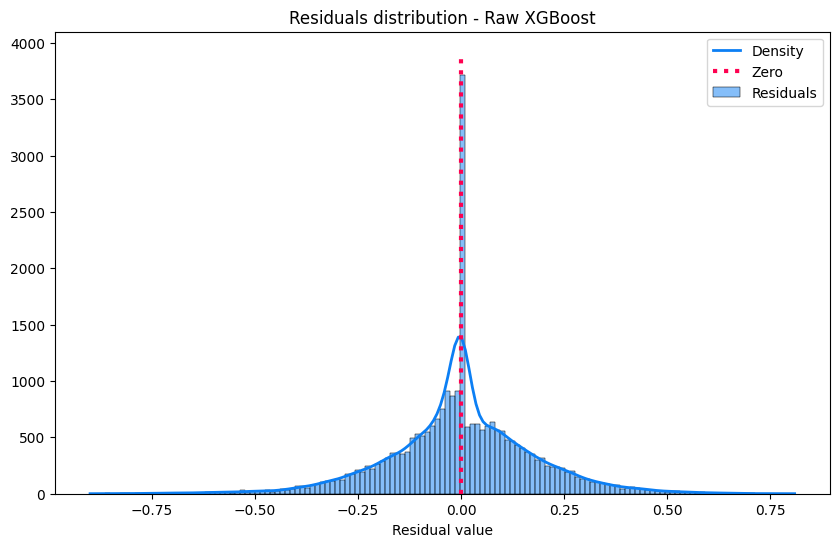

In [647]:
plot_residual_distribution(X_test, Y_test, regXGB, title)

#### Model resisuals vs true values

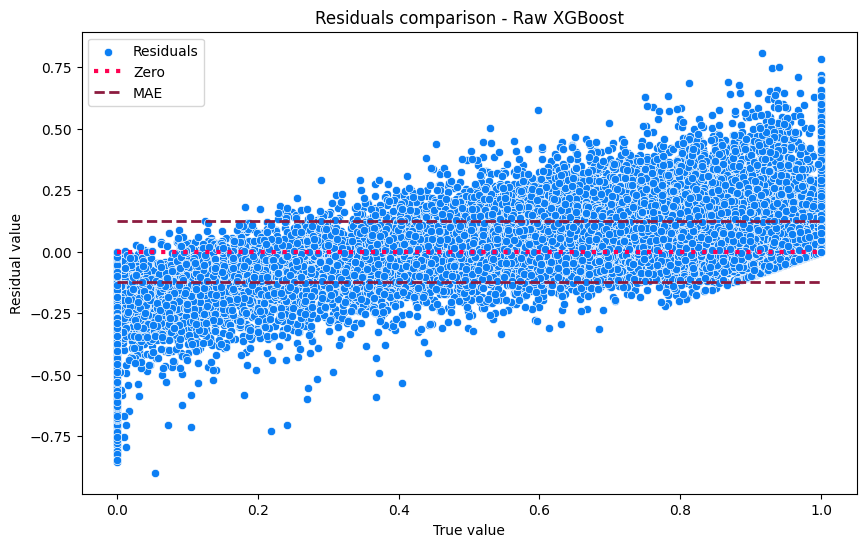

In [648]:
plot_residual_comparison(X_test, Y_test, regXGB, title)

#### Model features importance (SHAP values)

[16:50:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


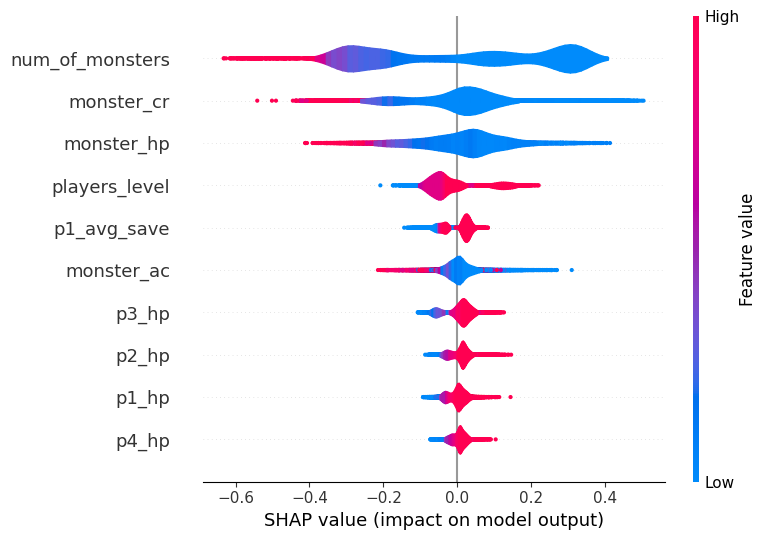

In [649]:
plot_feature_importance(regXGB, X_test);

### *Predicting the using the model*

In [650]:
predict(regXGB, X_test, Y_test)

Input: 
The combat was between 4 players level 3 against 10 monster(s) CR 0.25
Expected:  0.0
Predicted:  0.059726104
Delta: 0.06


## **Hyperparameter tuning using ``Optuna``**

### *Defining the objective function*

In [651]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 3, 7)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2, step=0.05)
    gamma = trial.suggest_float('gamma', 0.0, 0.3, step=0.1)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 7)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 0.7, step=0.1)
    base_score = trial.suggest_float('base_score', 0.2, 0.7, step=0.1)

    model = XGBRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        gamma=gamma,
        min_child_weight=min_child_weight,
        colsample_bytree=colsample_bytree,
        base_score=base_score,
        random_state=7, 
        n_jobs=-1,
        eval_metric='rmse',
        eval_set=[(X_train, Y_train),(X_test, Y_test)]
        )
    
    model.fit(
        X_train,
        Y_train,
        verbose=False
        )
    Y_pred = truncate_prediction(model, X_test)
    return mean_squared_error(Y_test, Y_pred)

### *Training the model's hyperparameters*

In [652]:
study = optuna.create_study(direction='minimize', study_name='regression')
study.optimize(objective, n_trials=200, n_jobs=-1) # type: ignore
study.best_params

[I 2023-12-15 16:50:51,333] A new study created in memory with name: regression
[I 2023-12-15 16:50:55,120] Trial 1 finished with value: 0.06090983879587764 and parameters: {'n_estimators': 62, 'max_depth': 4, 'learning_rate': 0.2, 'gamma': 0.1, 'min_child_weight': 5, 'colsample_bytree': 0.4, 'base_score': 0.30000000000000004}. Best is trial 1 with value: 0.06090983879587764.
[I 2023-12-15 16:50:55,657] Trial 5 finished with value: 0.07516299689905773 and parameters: {'n_estimators': 54, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0.1, 'min_child_weight': 4, 'colsample_bytree': 0.6000000000000001, 'base_score': 0.5}. Best is trial 1 with value: 0.06090983879587764.
[I 2023-12-15 16:50:56,121] Trial 7 finished with value: 0.07242303898301437 and parameters: {'n_estimators': 63, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0.1, 'min_child_weight': 1, 'colsample_bytree': 0.6000000000000001, 'base_score': 0.5}. Best is trial 1 with value: 0.06090983879587764.
[I 2023-12-15 16:50:56,

{'n_estimators': 200,
 'max_depth': 7,
 'learning_rate': 0.2,
 'gamma': 0.0,
 'min_child_weight': 6,
 'colsample_bytree': 0.7,
 'base_score': 0.7}

### *Model's best hyperparameters*

In [653]:
# FINAL_PARAMETERS_OPT = study.best_params
FINAL_PARAMETERS_OPT = {
  'n_estimators': 200,
  'max_depth': 7,
  'learning_rate': 0.2,
  'gamma': 0.0,
  'min_child_weight': 6,
  'colsample_bytree': 0.7,
  'base_score': 0.6
}

### *Making the regression model*

In [654]:
model_OPT = XGBRegressor(**FINAL_PARAMETERS_OPT,early_stopping_rounds=10,eval_metric='rmse')
model_OPT.fit(  
            X_train,
            Y_train,
            eval_set=[(X_train, Y_train),(X_test, Y_test)],
            verbose=20
          );

[0]	validation_0-rmse:0.37863	validation_1-rmse:0.37723


[20]	validation_0-rmse:0.22207	validation_1-rmse:0.22629
[40]	validation_0-rmse:0.19774	validation_1-rmse:0.20575
[60]	validation_0-rmse:0.18499	validation_1-rmse:0.19624
[80]	validation_0-rmse:0.17337	validation_1-rmse:0.18728
[100]	validation_0-rmse:0.16360	validation_1-rmse:0.18020
[120]	validation_0-rmse:0.15632	validation_1-rmse:0.17482
[140]	validation_0-rmse:0.14892	validation_1-rmse:0.16902
[160]	validation_0-rmse:0.14286	validation_1-rmse:0.16501
[180]	validation_0-rmse:0.13798	validation_1-rmse:0.16196
[199]	validation_0-rmse:0.13364	validation_1-rmse:0.15897


### *Looking at the model results*

In [655]:
title = 'XGBoost with Optuna'

#### Model scores on the test set

In [656]:
print_regression_report(X_test,Y_test,model_OPT,title)

XGBoost with Optuna
Mean Squared Error:		 0.02417401085939612
Mean Absolute Error:		 0.10726734837306529
R²:				 0.8452595178473619
Root Mean Squared Error:	 0.1554799371603813


#### Model resisuals distribution

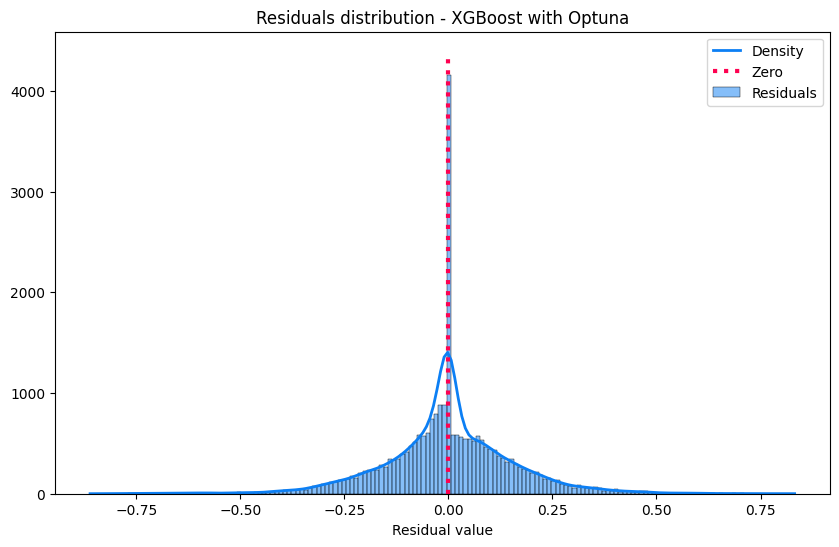

In [657]:
plot_residual_distribution(X_test, Y_test, model_OPT, title);

#### Model resisuals vs true values

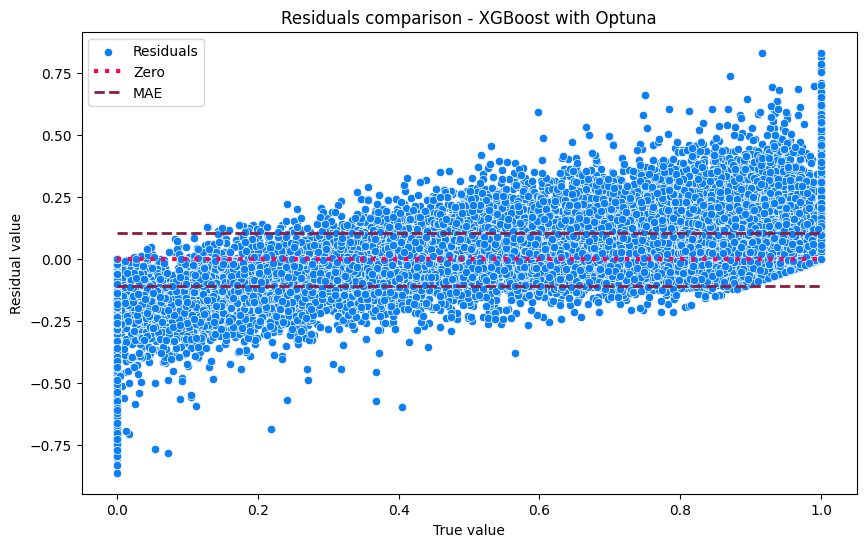

In [658]:
plot_residual_comparison(X_test, Y_test, model_OPT, title);

#### Model features importance (SHAP values)

[16:53:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


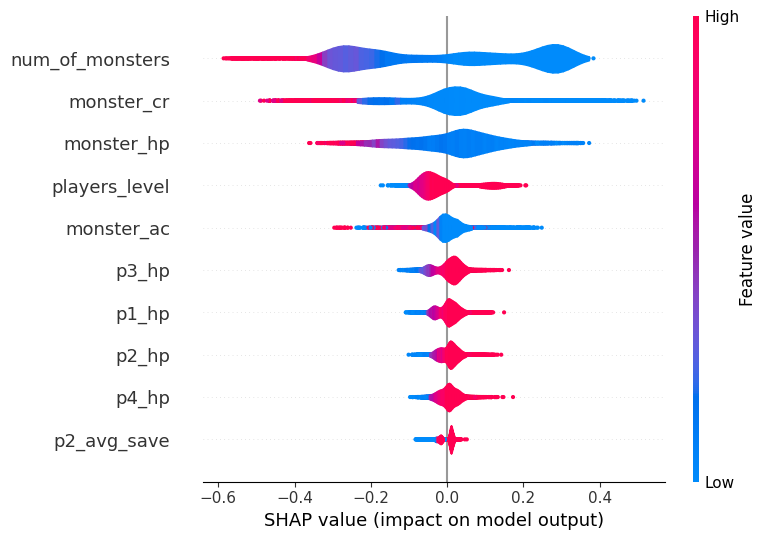

In [659]:
plot_feature_importance(model_OPT, X_test);

### *Making predictions*

In [660]:
predict(model_OPT, X_test, Y_test)

Input: 
The combat was between 4 players level 1 against 10 monster(s) CR 0.25
Expected:  0.0
Predicted:  0.02287755
Delta: 0.02


## **Scaling the data with ``StandardScaler`` beforehand**

### *Scaling the data*

In [661]:
scaler = StandardScaler()

scaler.fit(X_encoded)
X_encoded_scaled = scaler.transform(X_encoded)
df_test_encoded_scaled = scaler.transform(df_test_encoded)
X_encoded_scaled = pd.DataFrame(X_encoded_scaled, columns=X_encoded.columns)
df_test_encoded_scaled = pd.DataFrame(df_test_encoded_scaled, columns=df_test_encoded.columns)

### *Splitting the dataset into the Training set and Test set*

In [662]:
X_train_scaled, X_test_scaled, Y_train_scaled, Y_test_scaled = train_test_split(X_encoded_scaled, Y, test_size=.2)

### *Defining the objective function*

In [663]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 3, 7)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2, step=0.05)
    gamma = trial.suggest_float('gamma', 0.0, 0.3, step=0.1)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 7)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 0.7, step=0.1)
    base_score = trial.suggest_float('base_score', 0.2, 0.7, step=0.1)

    model = XGBRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        gamma=gamma,
        min_child_weight=min_child_weight,
        colsample_bytree=colsample_bytree,
        base_score=base_score,
        random_state=7, 
        n_jobs=-1,
        eval_metric='rmse',
        eval_set=[(X_train_scaled, Y_train_scaled),(X_test_scaled, Y_test_scaled)]
        )
    
    model.fit(
        X_train_scaled,
        Y_train_scaled,
        verbose=False
        )
    Y_pred = truncate_prediction(model, X_test_scaled)
    return mean_squared_error(Y_test_scaled, Y_pred)

### *Training the model's hyperparameters*

In [664]:
study = optuna.create_study(direction='minimize', study_name='regression')
study.optimize(objective, n_trials=200, n_jobs=-1) # type: ignore
study.best_params

[I 2023-12-15 16:54:15,004] A new study created in memory with name: regression
[I 2023-12-15 16:54:18,610] Trial 6 finished with value: 0.09262736845394474 and parameters: {'n_estimators': 79, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0.0, 'min_child_weight': 7, 'colsample_bytree': 0.4, 'base_score': 0.2}. Best is trial 6 with value: 0.09262736845394474.
[I 2023-12-15 16:54:19,010] Trial 3 finished with value: 0.06164853195076413 and parameters: {'n_estimators': 71, 'max_depth': 4, 'learning_rate': 0.2, 'gamma': 0.0, 'min_child_weight': 2, 'colsample_bytree': 0.3, 'base_score': 0.30000000000000004}. Best is trial 3 with value: 0.06164853195076413.
[I 2023-12-15 16:54:19,731] Trial 8 finished with value: 0.05076483983871967 and parameters: {'n_estimators': 71, 'max_depth': 5, 'learning_rate': 0.2, 'gamma': 0.0, 'min_child_weight': 3, 'colsample_bytree': 0.4, 'base_score': 0.6000000000000001}. Best is trial 8 with value: 0.05076483983871967.
[I 2023-12-15 16:54:19,765] Trial 11 fi

{'n_estimators': 200,
 'max_depth': 7,
 'learning_rate': 0.2,
 'gamma': 0.0,
 'min_child_weight': 2,
 'colsample_bytree': 0.7,
 'base_score': 0.30000000000000004}

#### Model's best hyperparameters

In [665]:
# FINAL_PARAMETERS_OPT_SCALED = study.best_params
FINAL_PARAMETERS_OPT_SCALED={
  'n_estimators': 196,
  'max_depth': 7,
  'learning_rate': 0.2,
  'gamma': 0.0,
  'min_child_weight': 6,
  'colsample_bytree': 0.5,
  'base_score': 0.2
}

### *Training the Regression model*

In [666]:
model_OPT_SCALED = XGBRegressor(**FINAL_PARAMETERS_OPT_SCALED, early_stopping_rounds=10,eval_metric='rmse')
model_OPT_SCALED.fit(
            X_train_scaled,
            Y_train_scaled,
            eval_set=[(X_train_scaled, Y_train_scaled),(X_test_scaled, Y_test_scaled)],
            verbose=20
          );

[0]	validation_0-rmse:0.44466	validation_1-rmse:0.44495
[20]	validation_0-rmse:0.23101	validation_1-rmse:0.23653
[40]	validation_0-rmse:0.20560	validation_1-rmse:0.21424
[60]	validation_0-rmse:0.19074	validation_1-rmse:0.20232
[80]	validation_0-rmse:0.17891	validation_1-rmse:0.19306
[100]	validation_0-rmse:0.16999	validation_1-rmse:0.18646
[120]	validation_0-rmse:0.16156	validation_1-rmse:0.18033
[140]	validation_0-rmse:0.15452	validation_1-rmse:0.17535
[160]	validation_0-rmse:0.14896	validation_1-rmse:0.17148
[180]	validation_0-rmse:0.14336	validation_1-rmse:0.16757
[195]	validation_0-rmse:0.14000	validation_1-rmse:0.16558


### *Looking at the model results*

In [667]:
title = 'XGBoost with Optuna and Scaled Data'

#### Model scores on the test set

In [668]:
print_regression_report(X_test_scaled,Y_test_scaled,model_OPT_SCALED,title)

XGBoost with Optuna and Scaled Data
Mean Squared Error:		 0.026406136677212658
Mean Absolute Error:		 0.11286833485786997
R²:				 0.8313320818110238
Root Mean Squared Error:	 0.1624996513141264


#### Model's resisuals distribution

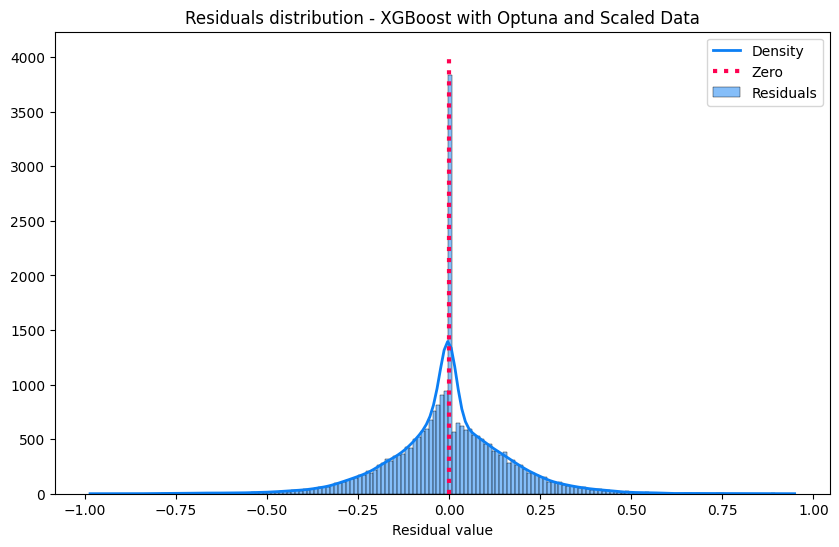

In [669]:
plot_residual_distribution(X_test_scaled, Y_test_scaled, model_OPT_SCALED, title);

#### Model's resisuals vs true values

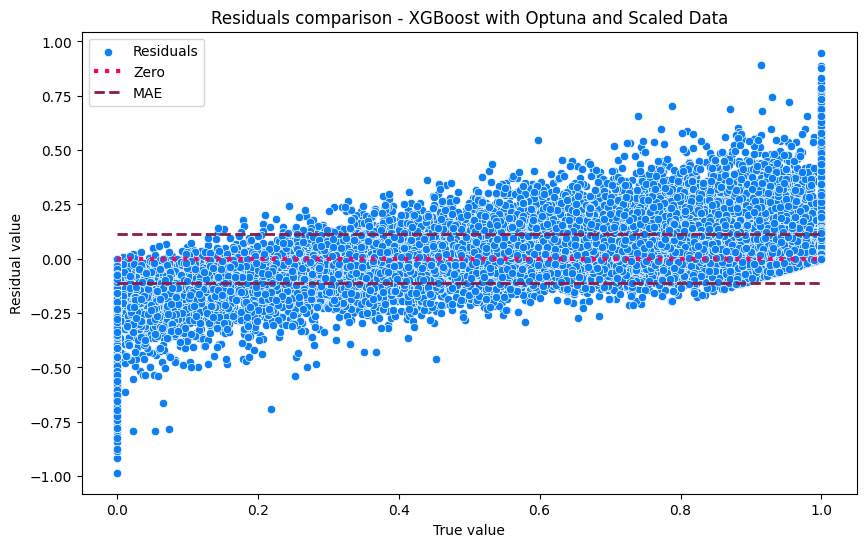

In [670]:
plot_residual_comparison(X_test_scaled, Y_test_scaled, model_OPT_SCALED, title);

#### Model features importance (SHAP values)

[16:57:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


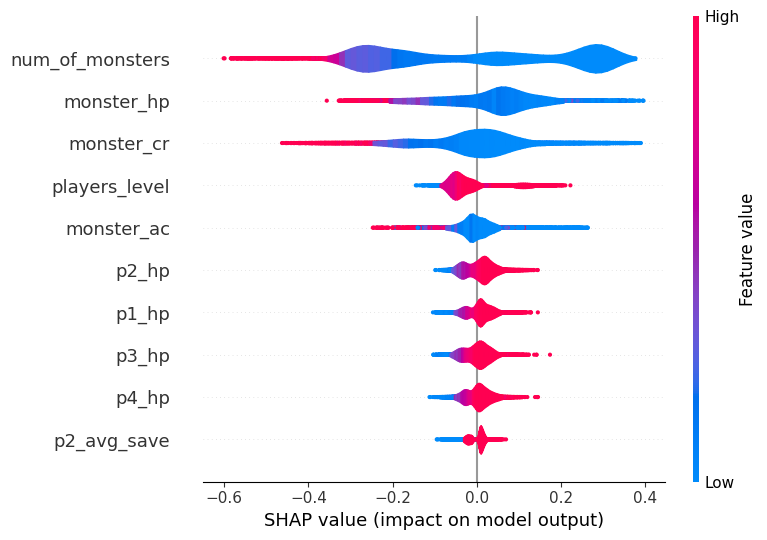

In [671]:
plot_feature_importance(model_OPT_SCALED, X_test_scaled);

### *Making predictions*

In [672]:
predict(model_OPT_SCALED, X_test_scaled, Y_test_scaled, scaler=scaler)

Input: 
The combat was between 4 players level 1 against 10 monster(s) CR 0.5
Expected:  0.0
Predicted:  0.0011016156
Delta: 0.0


## **Normalizing the data with ``MinMaxScaller`` beforehand**

### *Normalizing the data*

In [673]:
normalizer = MinMaxScaler()

normalizer.fit(X_encoded)
X_encoded_normalized = normalizer.transform(X_encoded)
df_test_encoded_nomalized = normalizer.transform(df_test_encoded)
X_encoded_normalized = pd.DataFrame(X_encoded_normalized, columns=X_encoded.columns)
df_test_encoded_nomalized = pd.DataFrame(df_test_encoded_nomalized, columns=df_test_encoded.columns)

### *Splitting the dataset into the Training set and Test set*

In [674]:
X_train_normalized, X_test_normalized, Y_train_normalized, Y_test_normalized = train_test_split(X_encoded_normalized, Y, test_size=.2)

### *Defining the objective function*

In [675]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 3, 7)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2, step=0.05)
    gamma = trial.suggest_float('gamma', 0.0, 0.3, step=0.1)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 7)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 0.7, step=0.1)
    base_score = trial.suggest_float('base_score', 0.2, 0.7, step=0.1)

    model = XGBRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        gamma=gamma,
        min_child_weight=min_child_weight,
        colsample_bytree=colsample_bytree,
        base_score=base_score,
        random_state=7, 
        n_jobs=-1,
        eval_metric='rmse',
        eval_set=[(X_train_normalized, Y_train_normalized),(X_test_normalized, Y_test_normalized)]
        )
    
    model.fit(
        X_train_normalized,
        Y_train_normalized,
        verbose=False
        )
    Y_pred = truncate_prediction(model, X_test_normalized)
    return mean_squared_error(Y_test_normalized, Y_pred)

### *Training the model's hyperparameters*

In [676]:
study = optuna.create_study(direction='minimize', study_name='regression')
study.optimize(objective, n_trials=200, n_jobs=-1)
study.best_params

[I 2023-12-15 16:57:16,232] A new study created in memory with name: regression
[I 2023-12-15 16:57:20,109] Trial 7 finished with value: 0.05675894251836159 and parameters: {'n_estimators': 53, 'max_depth': 5, 'learning_rate': 0.2, 'gamma': 0.0, 'min_child_weight': 1, 'colsample_bytree': 0.3, 'base_score': 0.5}. Best is trial 7 with value: 0.05675894251836159.
[I 2023-12-15 16:57:20,717] Trial 0 finished with value: 0.0712779770333547 and parameters: {'n_estimators': 104, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.0, 'min_child_weight': 1, 'colsample_bytree': 0.6000000000000001, 'base_score': 0.4}. Best is trial 7 with value: 0.05675894251836159.
[I 2023-12-15 16:57:20,813] Trial 10 finished with value: 0.061921210840326806 and parameters: {'n_estimators': 103, 'max_depth': 3, 'learning_rate': 0.2, 'gamma': 0.3, 'min_child_weight': 4, 'colsample_bytree': 0.6000000000000001, 'base_score': 0.2}. Best is trial 7 with value: 0.05675894251836159.
[I 2023-12-15 16:57:21,705] Trial 6 fi

{'n_estimators': 200,
 'max_depth': 7,
 'learning_rate': 0.2,
 'gamma': 0.0,
 'min_child_weight': 4,
 'colsample_bytree': 0.6000000000000001,
 'base_score': 0.4}

#### Model's best hyperparameters

In [677]:
# FINAL_PARAMETERS_OPT_NORMALIZED = study.best_params
FINAL_PARAMETERS_OPT_NORMALIZED={
    'n_estimators': 200,
    'max_depth': 7,
    'learning_rate': 0.2,
    'gamma': 0.0,
    'min_child_weight': 7,
    'colsample_bytree': 0.4,
    'base_score': 0.7
}

### *Training the Regression model*

In [678]:
model_OPT_NORMALIZED = XGBRegressor(**FINAL_PARAMETERS_OPT_NORMALIZED, early_stopping_rounds=10,eval_metric='rmse')
model_OPT_NORMALIZED.fit(
            X_train_normalized,
            Y_train_normalized,
            eval_set=[(X_train_normalized, Y_train_normalized),(X_test_normalized, Y_test_normalized)],
            verbose=20
          );

[0]	validation_0-rmse:0.43300	validation_1-rmse:0.43306
[20]	validation_0-rmse:0.23630	validation_1-rmse:0.24109
[40]	validation_0-rmse:0.20608	validation_1-rmse:0.21370
[60]	validation_0-rmse:0.19138	validation_1-rmse:0.20179
[80]	validation_0-rmse:0.18037	validation_1-rmse:0.19371
[100]	validation_0-rmse:0.17247	validation_1-rmse:0.18788
[120]	validation_0-rmse:0.16759	validation_1-rmse:0.18527
[140]	validation_0-rmse:0.16093	validation_1-rmse:0.18069
[160]	validation_0-rmse:0.15551	validation_1-rmse:0.17693
[180]	validation_0-rmse:0.15029	validation_1-rmse:0.17300
[199]	validation_0-rmse:0.14443	validation_1-rmse:0.16886


### *Looking at the model results*

In [679]:
title = 'XGBoost with Optuna and Normalized Data'

#### Model scores on the test set

In [680]:
print_regression_report(X_test_normalized,Y_test_normalized,model_OPT_NORMALIZED,title)

XGBoost with Optuna and Normalized Data
Mean Squared Error:		 0.027342633787820567
Mean Absolute Error:		 0.11532331072751972
R²:				 0.8266284023757828
Root Mean Squared Error:	 0.16535608179870664


#### Model's resisuals distribution

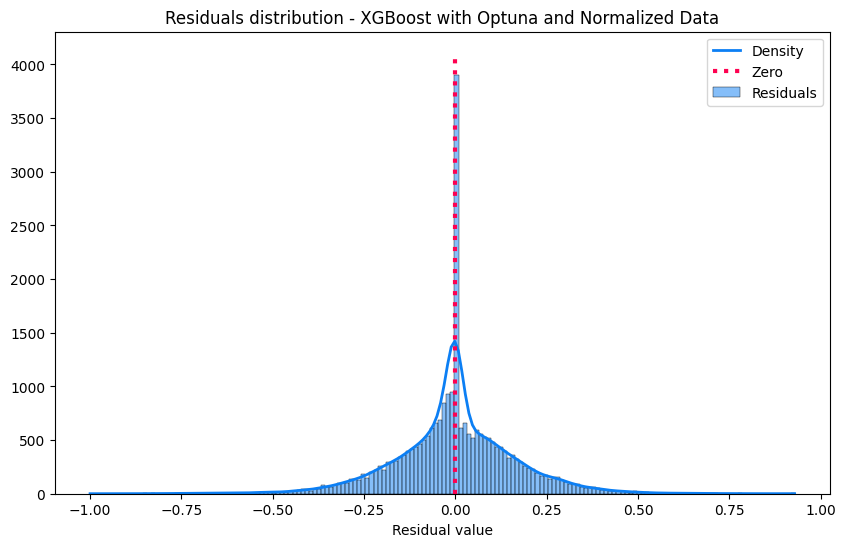

In [681]:
plot_residual_distribution(X_test_normalized, Y_test_normalized, model_OPT_NORMALIZED, title);

#### Model's resisuals vs true values

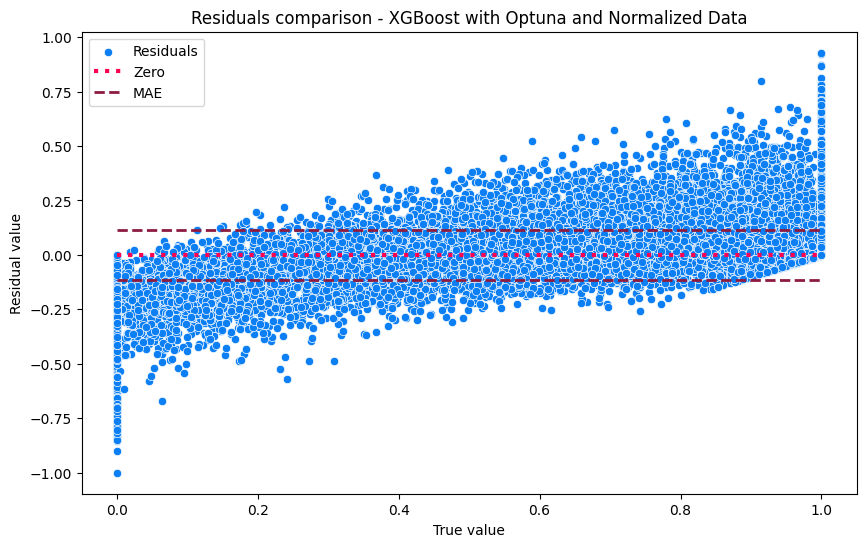

In [682]:
plot_residual_comparison(X_test_normalized, Y_test_normalized, model_OPT_NORMALIZED, title);

#### Model features importance (SHAP values)

[17:00:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


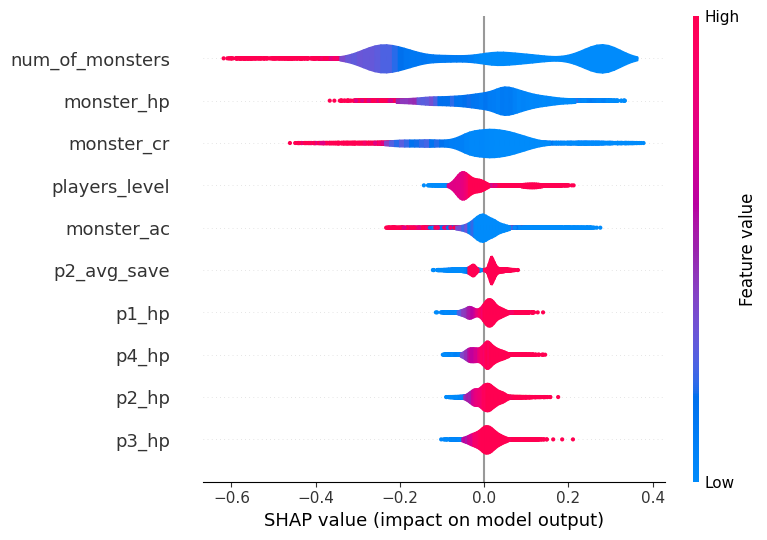

In [683]:
plot_feature_importance(model_OPT_NORMALIZED, X_test_normalized);

### *Making predictions*

In [684]:
predict(model_OPT_NORMALIZED, X_test_normalized, Y_test_normalized, normalizer=normalizer)

Input: 
The combat was between 4 players level 4 against 2 monster(s) CR 4.0
Expected:  0.2438049106887349
Predicted:  0.36270177
Delta: 0.12


# ***Comparing all four models***

## **Comparing the models metrics**

### *Creating the dataframe with all models results*

In [685]:
results = {
    'Raw XGBoost': {
        'R2': r2_score(Y_test, truncate_prediction(regXGB, X_test)),
        'RMSE': np.sqrt(mean_squared_error(Y_test, truncate_prediction(regXGB, X_test))),
        'MSE': mean_squared_error(Y_test, truncate_prediction(regXGB, X_test)),
        'MAE': mean_absolute_error(Y_test, truncate_prediction(regXGB, X_test))
    },
    'XGBoost with Optuna': {
        'R2': r2_score(Y_test, truncate_prediction(model_OPT, X_test)),
        'RMSE': np.sqrt(mean_squared_error(Y_test, truncate_prediction(model_OPT, X_test))),
        'MSE': mean_squared_error(Y_test, truncate_prediction(model_OPT, X_test)),
        'MAE': mean_absolute_error(Y_test, truncate_prediction(model_OPT, X_test))
    },
    'XGBoost with Optuna and Scaled Data': {
        'R2': r2_score(Y_test_scaled, truncate_prediction(model_OPT_SCALED, X_test_scaled)),
        'RMSE': np.sqrt(mean_squared_error(Y_test_scaled, truncate_prediction(model_OPT_SCALED, X_test_scaled))),
        'MSE': mean_squared_error(Y_test_scaled, truncate_prediction(model_OPT_SCALED, X_test_scaled)),
        'MAE': mean_absolute_error(Y_test_scaled, truncate_prediction(model_OPT_SCALED, X_test_scaled))
    },
    'XGBoost with Optuna and Normalized Data': {
        'R2': r2_score(Y_test_normalized, truncate_prediction(model_OPT_NORMALIZED, X_test_normalized)),
        'RMSE': np.sqrt(mean_squared_error(Y_test_normalized, truncate_prediction(model_OPT_NORMALIZED, X_test_normalized))),
        'MSE': mean_squared_error(Y_test_normalized, truncate_prediction(model_OPT_NORMALIZED, X_test_normalized)),
        'MAE': mean_absolute_error(Y_test_normalized, truncate_prediction(model_OPT_NORMALIZED, X_test_normalized))
    }
}

### *Comparing the models*

In [686]:
models_metrics = pd.DataFrame(results).T.sort_values(by='R2', ascending=False)
models_metrics

,R2,RMSE,MSE,MAE
XGBoost with Optuna,0.845260,0.155480,0.024174,0.107267
XGBoost with Optuna and Scaled Data,0.831332,0.162500,0.026406,0.112868
XGBoost with Optuna and Normalized Data,0.826628,0.165356,0.027343,0.115323
Raw XGBoost,0.804173,0.174908,0.030593,0.123850


## **Comparing models behaviors**

In [687]:
models = [[{'Raw XGBoost':[regXGB,X_test,Y_test]}, {'XGBoost with Optune':[model_OPT,X_test,Y_test]}],[{'XGBoost with Optune and Scaled':[model_OPT_SCALED,X_test_scaled,Y_test_scaled]}, {'XGBoost with Optune and Normalized':[model_OPT_NORMALIZED,X_test_normalized,Y_test_normalized]}]]

### *Comparing the models residuals distributions*

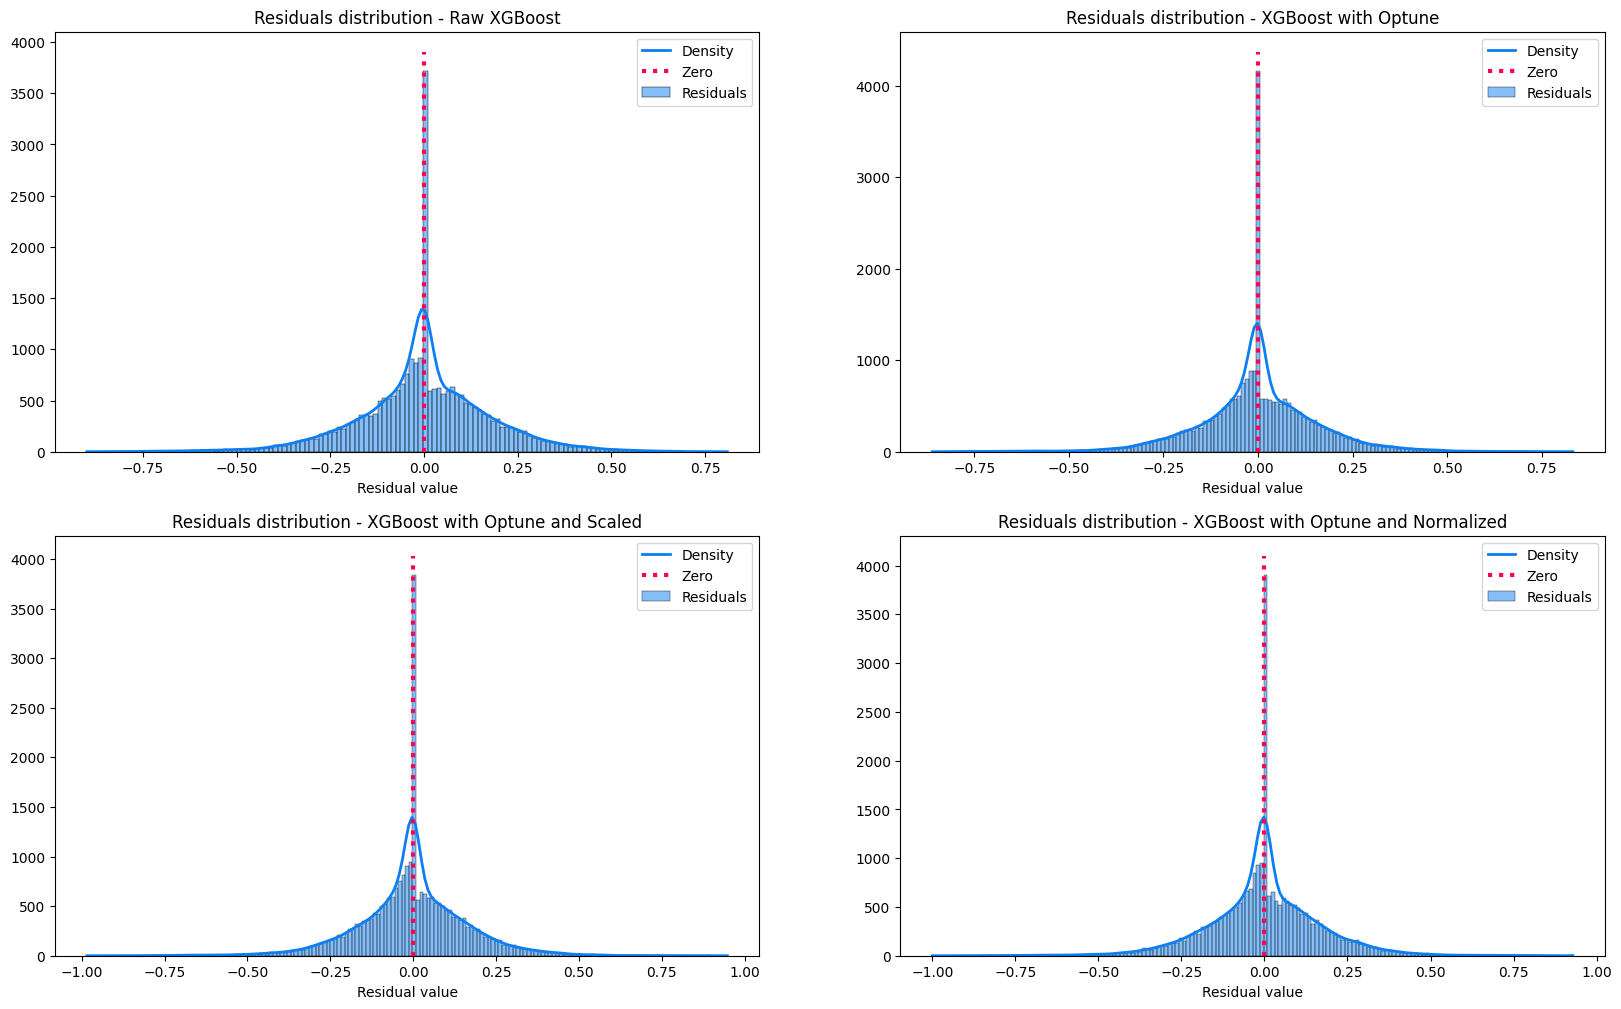

In [688]:
fig, axes = plt.subplots(2,2,figsize=(20, 12))

for i in range(2):
    for j in range(2):
        model = list(models[i][j].values())[0][0]
        x_test = list(models[i][j].values())[0][1]
        Y_test = list(models[i][j].values())[0][2]
        title = list(models[i][j].keys())[0]
        sns.histplot(Y_test - truncate_prediction(model,x_test), color=COLORS[2], kde=True, label='Residuals', line_kws={'linewidth': 2, 'label': 'Density'}, ax=axes[i][j])
        axes[i][j].set_title(f'Residuals distribution - {title}')
        axes[i][j].set_xlabel('Residual value')
        axes[i][j].set_ylabel('')
        axes[i][j].vlines(0, axes[i][j].get_ylim()[0], axes[i][j].get_ylim()[1], colors=COLORS[1], linestyles=':', label='Zero', linewidth=3)
        axes[i][j].legend();



### *Changing the y axis scale*

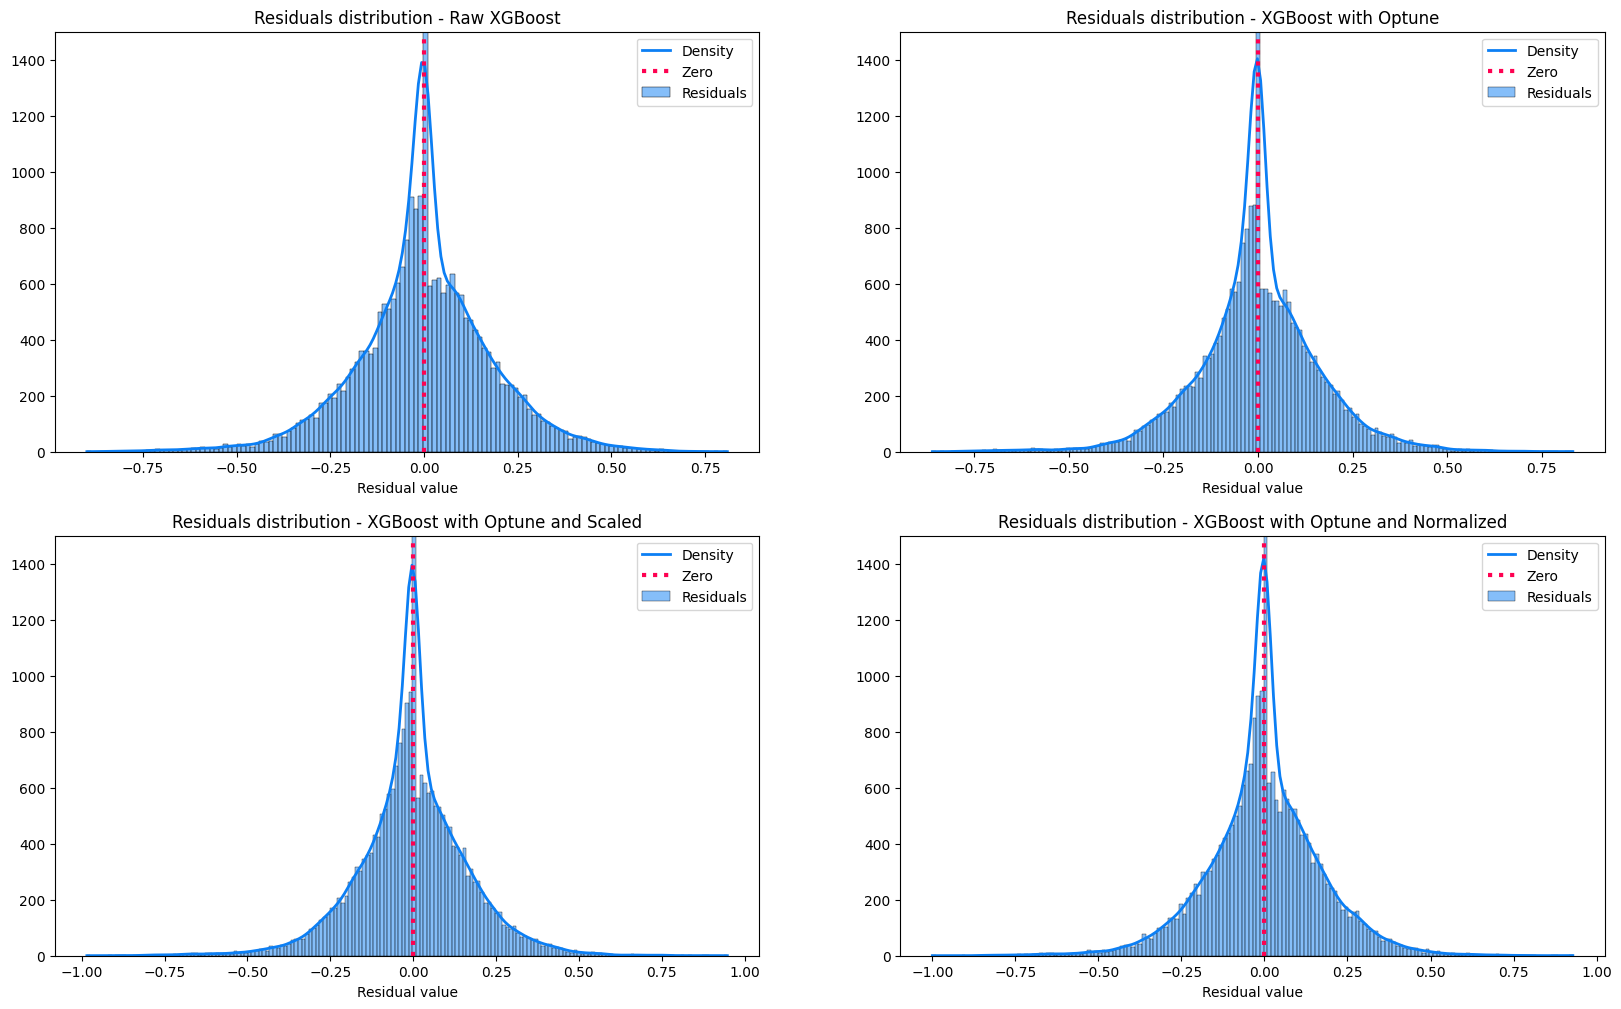

In [689]:
fig, axes = plt.subplots(2,2,figsize=(20, 12))

for i in range(2):
    for j in range(2):
        model = list(models[i][j].values())[0][0]
        x_test = list(models[i][j].values())[0][1]
        Y_test = list(models[i][j].values())[0][2]
        title = list(models[i][j].keys())[0]
        sns.histplot(Y_test - truncate_prediction(model,x_test), color=COLORS[2], kde=True, label='Residuals', line_kws={'linewidth': 2, 'label': 'Density'}, ax=axes[i][j])
        axes[i][j].set_title(f'Residuals distribution - {title}')
        axes[i][j].set_xlabel('Residual value')
        axes[i][j].set_ylabel('')
        axes[i][j].set_ylim(0, 1500)
        axes[i][j].vlines(0, axes[i][j].get_ylim()[0], axes[i][j].get_ylim()[1], colors=COLORS[1], linestyles=':', label='Zero', linewidth=3)
        axes[i][j].legend();



### *Comparing the models residuals vs true values*

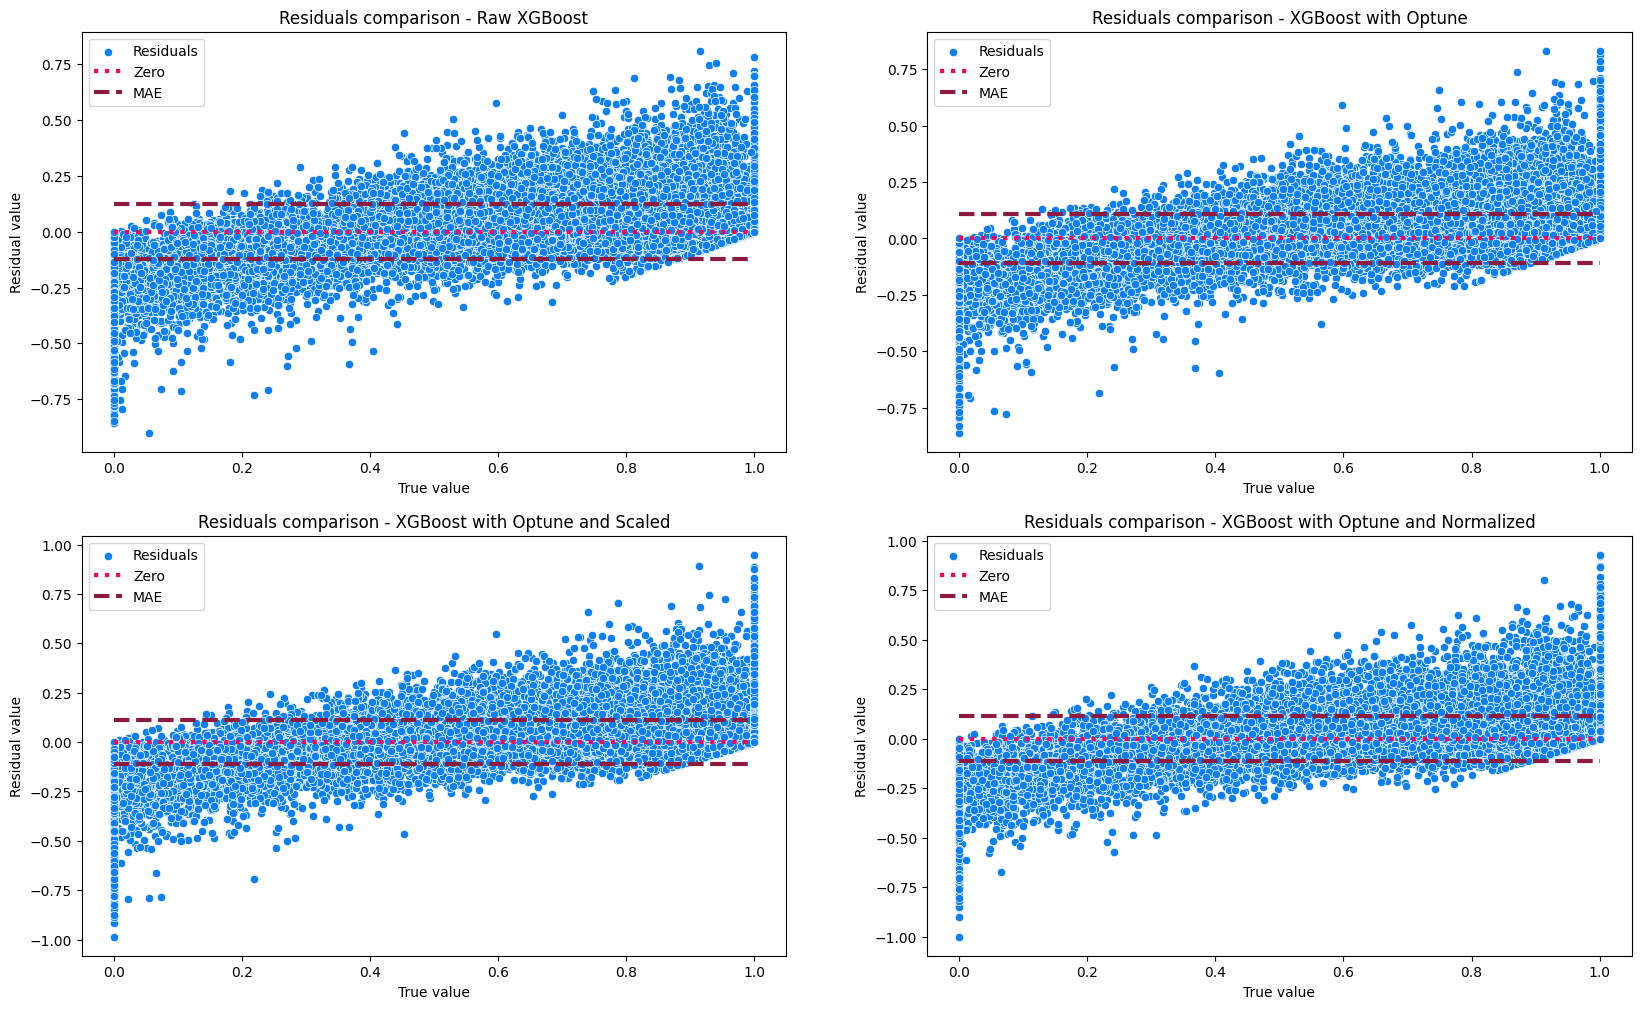

In [690]:
fig, axes = plt.subplots(2,2,figsize=(20, 12))

for i in range(2):
    for j in range(2):
        ax = axes[i][j]
        model = list(models[i][j].values())[0][0]
        x_test = list(models[i][j].values())[0][1]
        y_test = list(models[i][j].values())[0][2]
        title = list(models[i][j].keys())[0]
        sns.scatterplot(x=y_test, y=y_test-truncate_prediction(model,x_test), color=COLORS[2], label='Residuals',ax=ax)
        ax.set_title(f'Residuals comparison - {title}')
        ax.set_xlabel('True value')
        ax.set_ylabel('Residual value')
        ax.hlines(0, 0, 1, colors=COLORS[1], linestyles=':', label='Zero', linewidth=3)
        ax.hlines(mean_absolute_error(y_test, truncate_prediction(model, x_test)), 0, 1, colors=COLORS[0], linestyles='--', label='MAE', linewidth=3)
        ax.hlines(-mean_absolute_error(y_test, truncate_prediction(model, x_test)), 0, 1, colors=COLORS[0], linestyles='--', linewidth=3)
        ax.legend();

### *Changing the scale to try and focus on the error*

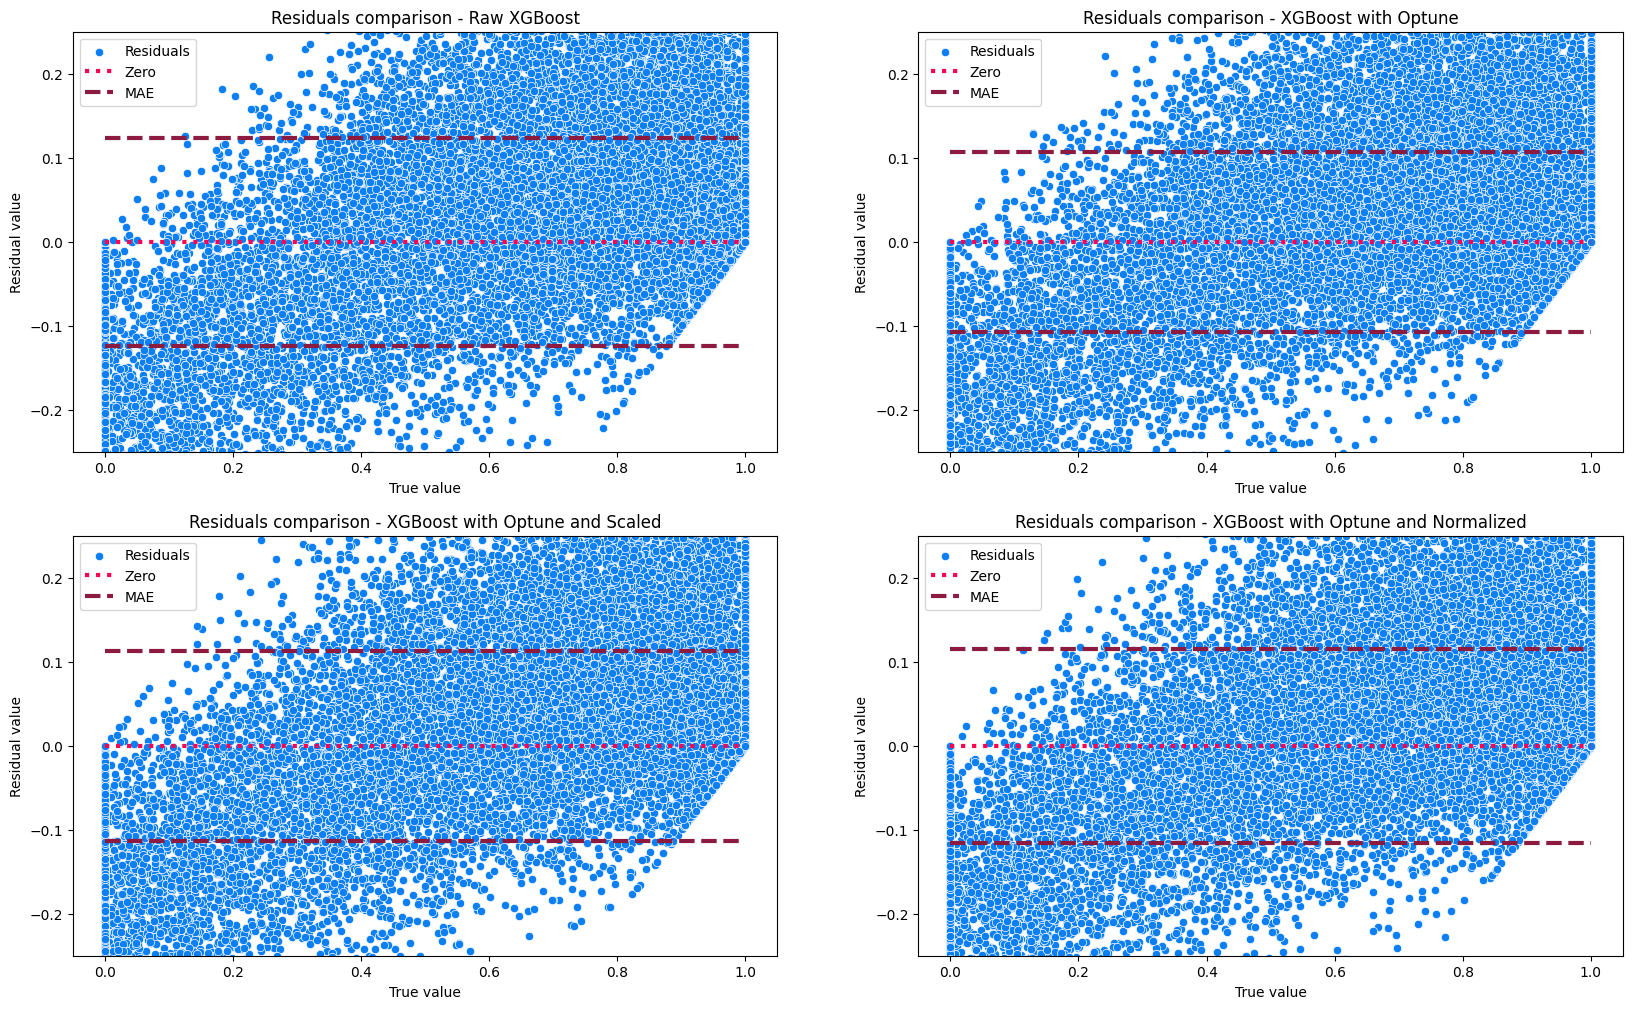

In [691]:
fig, axes = plt.subplots(2,2,figsize=(20, 12))

for i in range(2):
    for j in range(2):
        ax = axes[i][j]
        model = list(models[i][j].values())[0][0]
        x_test = list(models[i][j].values())[0][1]
        y_test = list(models[i][j].values())[0][2]
        title = list(models[i][j].keys())[0]
        sns.scatterplot(x=y_test, y=y_test-truncate_prediction(model,x_test), color=COLORS[2], label='Residuals',ax=ax)
        ax.set_title(f'Residuals comparison - {title}')
        ax.set_xlabel('True value')
        ax.set_ylabel('Residual value')
        ax.set_ylim(-0.25, 0.25)
        ax.hlines(0, 0, 1, colors=COLORS[1], linestyles=':', label='Zero', linewidth=3)
        ax.hlines(mean_absolute_error(y_test, truncate_prediction(model, x_test)), 0, 1, colors=COLORS[0], linestyles='--', label='MAE', linewidth=3)
        ax.hlines(-mean_absolute_error(y_test, truncate_prediction(model, x_test)), 0, 1, colors=COLORS[0], linestyles='--', linewidth=3)
        ax.legend();

# ***Saving the best model***

In [694]:
model_OPT.save_model('../Model/Regreesion_XGBoost_OPT_v2.ubj')